## Links

* [Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)
* [T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)
* [Optuna Tutorial](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/001_first.html#sphx-glr-tutorial-10-key-features-001-first-py)
* [Optuna Trials](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial)
* [Optuna Visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [3]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import numpy as np

import ray

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import balanced_accuracy_score

# Pandas...
import pandas as pd
from pandas_profiling import ProfileReport

# Pytorch...
import torch
from torch.optim import Adam, SGD
from torch.nn    import Sequential, \
                        Softmax, \
                        LeakyReLU

# Optuna...
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_contour, \
                                 plot_edf, \
                                 plot_intermediate_values, \
                                 plot_optimization_history, \
                                 plot_parallel_coordinate, \
                                 plot_param_importances, \
                                 plot_slice

# Own libs...

from callbacks import PlotMetrics, \
                      Logger, \
                      ReduceLROnPlateau, \
                      TrainValLossComputer, \
                      TrainValAccuracyComputer

from model     import CommonModel, \
                      softmax_cross_entropy_fn, \
                      softmax_pred_out, \
                      dense_stack

from utils     import try_gpu, dict_join
from callbacks import CallbackSet
from metrics   import show_summary
from data      import to_single_col_df

from optimizer import optimizer_sumary, \
                      ValAccPruneCallback, \
                      plot_trials_metric_dist


from plot import plot_hist, \
                 local_bin

In [4]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')

In [5]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [6]:
INDIVIDUAL_FEATURES = [
    'Overal',
    'Potential',
    'Height',
    'Weight',
    'PreferredFoot',
    'Age',
    'PlayerWorkRate',
    'WeakFoot',
    'SkillMoves', 
    'Value',
    'Wage',
    'Club',
    'Club_KitNumber',
    'Club_JoinedClub',
    'Club_ContractLength'
]

SKILL_FEATURES = [
    'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression',
    'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass',
    'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed',
    'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots',
    'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKReflexes'
]
TARGET = 'Position'

CAL_COLS = [ 'PreferredFoot', 'PlayerWorkRate']

In [7]:
def columns_with_missing(df): return [col for col in df.columns if df[col].isnull().any()]

In [8]:
feature_columns = list(set(INDIVIDUAL_FEATURES + SKILL_FEATURES) -  set(columns_with_missing(train_set)))

In [9]:
train_set = train_set[feature_columns + [TARGET]]

In [10]:
def preprocess(df):
    df = df.dropna()
    features = df[feature_columns]

    for col in CAL_COLS:
        features = pd.concat([features, pd.get_dummies(features[col], dummy_na=False)], axis=1)
    features = features.drop(CAL_COLS, axis=1)
    
    target = pd.get_dummies(df[[TARGET]], dummy_na=False) if TARGET in df.columns else None

    return features, target

In [11]:
def plot_df_clases_count(df, class_col):
    groups = train_set[[class_col]] \
      .groupby(class_col) \
      .size() \
      .reset_index(name='count')
    sns.barplot(data=groups, x=class_col, y='count')

def plot_array_clases_count(values):
    groups = values \
        .mean() \
        .reset_index(name='count') \
        .rename(columns={"index": "Name"})

    sns.barplot(data=groups, x="Name", y='count')

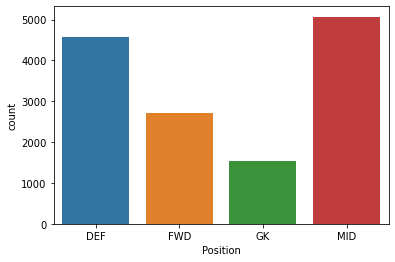

In [12]:
plot_df_clases_count(train_set, TARGET)

In [13]:
X, y = preprocess(train_set)

## Hyper parameters optimization

In [14]:
class MyModel(CommonModel):
    def __init__(
        self, 
        n_units, 
        lr,
        momentum,
        dropout, 
        negative_slope
    ):
        model = Sequential(*dense_stack(
            n_units, 
            LeakyReLU(negative_slope=negative_slope), dropout), Softmax(dim=1)
        ).to(device=try_gpu())

        optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)

        super().__init__(model, softmax_cross_entropy_fn, optimizer, softmax_pred_out)

In [15]:
import logging

def listener_configurer():
    root = logging.getLogger()
    console_handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s %(processName)-10s %(name)s %(levelname)-1s %(message)s')
    console_handler.setFormatter(formatter)
    root.addHandler(console_handler)
    root.setLevel(logging.INFO)
    
listener_configurer()

In [16]:
import multiprocessing

def train_fold(X, y, fold, train_idx, val_idx, params, callbacks=[]):
    logging.info('Fold {}'.format(fold + 1))
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val,   y_val   = X.iloc[val_idx],   y.iloc[val_idx]

    model = MyModel(
        n_units        = [X_train.shape[1], params['hidden_units'], y_train.shape[1]],
        lr             = params['lr'],
        momentum       = params['momentum'],
        dropout        = params['dropout'],
        negative_slope = params['relu_neg_slope']
    )

    model.fit(
        train_set    = (X_train, y_train), 
        val_set      = (X_val, y_val),
        batch_size   = params['batch_size'],
        epochs       = params['epochs'],
        callback_set = CallbackSet(
            [
                TrainValLossComputer(),
                TrainValAccuracyComputer(),
                Logger(metrics=['epoch', 'train_acc', 'val_acc'])
            ] + callbacks 
        )
    )

    y_true = to_single_col_df(np.argmax(y_val.values, axis=1))
    y_pred = to_single_col_df(model.predict(X_val))

    return balanced_accuracy_score(y_true, y_pred)
    

def train(X, y, params, callbacks=[], k_fold=5):
    np.random.seed(params['seed'])

    folds = StratifiedKFold(n_splits=k_fold, shuffle=True) \
            .split(X, y.values.argmax(1))

    params = [(X, y, fold, train_idx, val_idx, params, callbacks) for fold, (train_idx, val_idx) in enumerate(folds)]

    pool = multiprocessing.Pool(processes=24)

    return np.mean(pool.starmap(train_fold, params))

In [17]:
def objetive(trial):
    return train(
        X,
        y,
        params = {
            'hidden_units':   trial.suggest_int  ('hidden_units',   50,   500,   step = 10  ),
            'lr':             trial.suggest_float('lr',             1e-6, 1e-1),
            'momentum':       trial.suggest_float('momentum',       0.01, 0.9,   step = 0.01),
            'dropout':        trial.suggest_float('dropout',        0.0,  0.4,   step = 0.05),
            'batch_size':     trial.suggest_int  ('batch_size',     256,  521,   step = 32  ),
            'epochs':         trial.suggest_int  ('epochs',         100,  1500,  step = 10  ),
            'seed':           trial.suggest_int  ('seed',           100,  1000,  step = 10  ),
            'relu_neg_slope': trial.suggest_float('relu_neg_slope', 0.0,  0.2,   step = 0.01)
        },
        callbacks = [ValAccPruneCallback(trial)],
        k_fold    = 5
    )

# study = optuna.create_study(storage="sqlite:///example.db", study_name="my-studio-30", direction="maximize")

study = optuna.create_study(direction="maximize")

study.optimize(
    objetive,
    n_trials = 50,
    timeout  = 1500
)

[I 2021-12-21 23:24:10,878] A new study created in memory with name: no-name-fa9e087c-ca1c-45cd-9225-d9057ab54bf7
2021-12-21 23:24:11,038 ForkPoolWorker-1 root INFO Fold 1
2021-12-21 23:24:11,043 ForkPoolWorker-2 root INFO Fold 2
2021-12-21 23:24:11,048 ForkPoolWorker-3 root INFO Fold 3
2021-12-21 23:24:11,053 ForkPoolWorker-4 root INFO Fold 4
2021-12-21 23:24:11,061 ForkPoolWorker-5 root INFO Fold 5
2021-12-21 23:24:19,850 ForkPoolWorker-3 root INFO {'epoch': 50, 'train_acc': 0.25, 'val_acc': 0.25}
2021-12-21 23:24:19,946 ForkPoolWorker-4 root INFO {'epoch': 50, 'train_acc': 0.25, 'val_acc': 0.25}
2021-12-21 23:24:20,152 ForkPoolWorker-1 root INFO {'epoch': 50, 'train_acc': 0.8690897920803385, 'val_acc': 0.8637103402846495}
2021-12-21 23:24:20,301 ForkPoolWorker-5 root INFO {'epoch': 50, 'train_acc': 0.8818942850217182, 'val_acc': 0.8755973772725978}
2021-12-21 23:24:20,515 ForkPoolWorker-2 root INFO {'epoch': 50, 'train_acc': 0.25, 'val_acc': 0.25}
2021-12-21 23:24:28,513 ForkPoolWor

In [18]:
optimizer_sumary(study)

Study statistics: 
  Number of finished trials:  14
  Number of pruned trials:  0
  Number of complete trials:  14
Best trial:
  Value:  0.9004019283785695
  Params: 
    hidden_units: 170
    lr: 0.020831522168028097
    momentum: 0.08
    dropout: 0.25
    batch_size: 320
    epochs: 1150
    seed: 900
    relu_neg_slope: 0.02


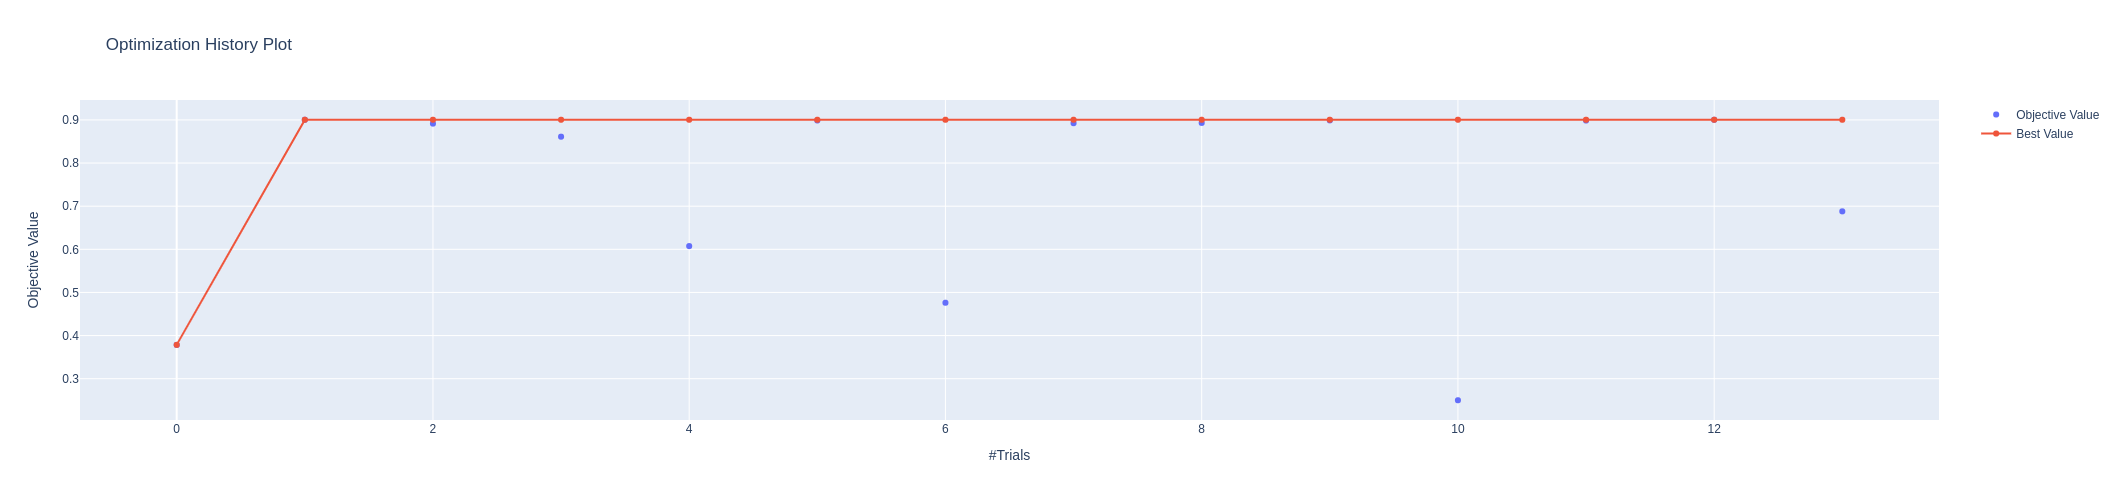

In [19]:
fig = plot_optimization_history(study)
fig.update_layout(width=1000, height=500)

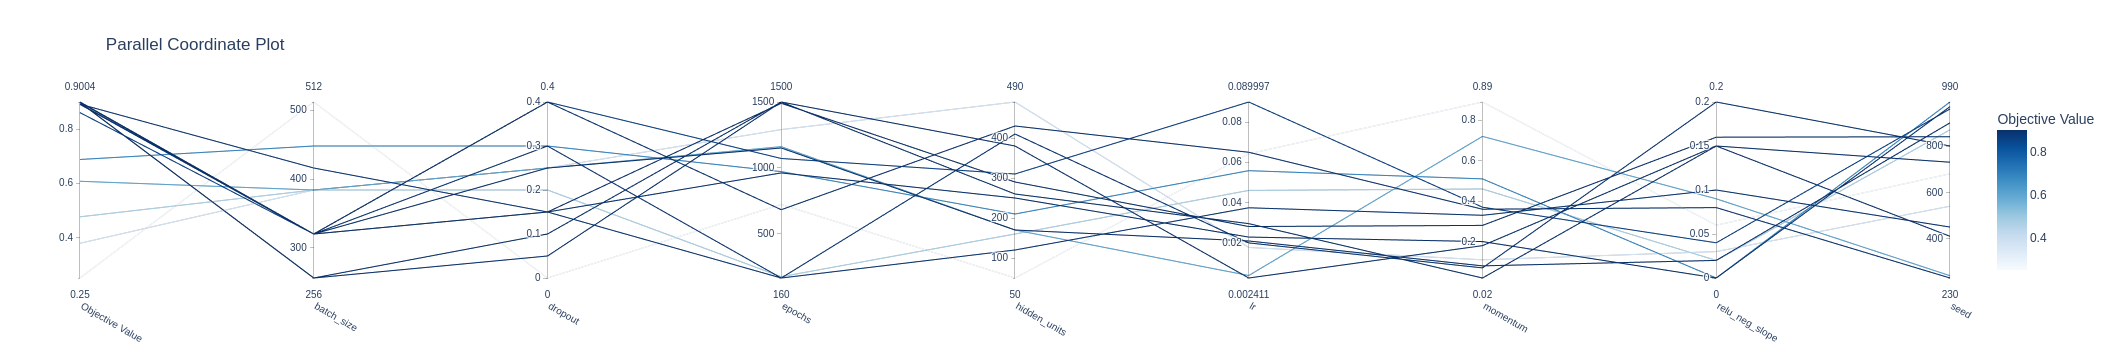

In [20]:
plot_parallel_coordinate(study)

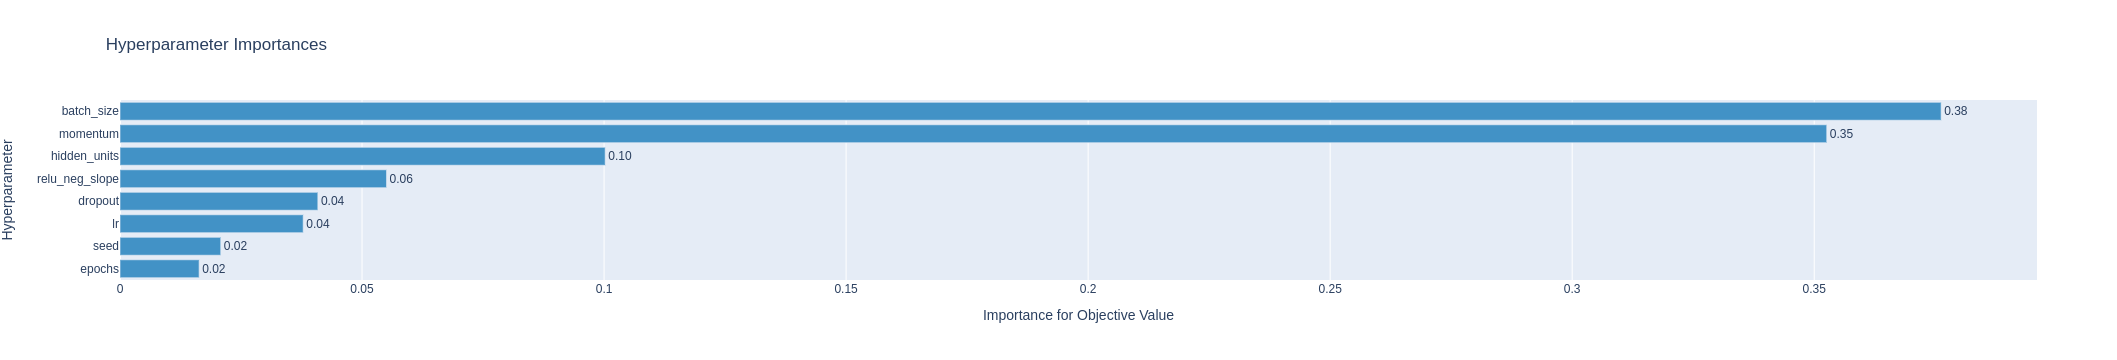

In [21]:
plot_param_importances(study)

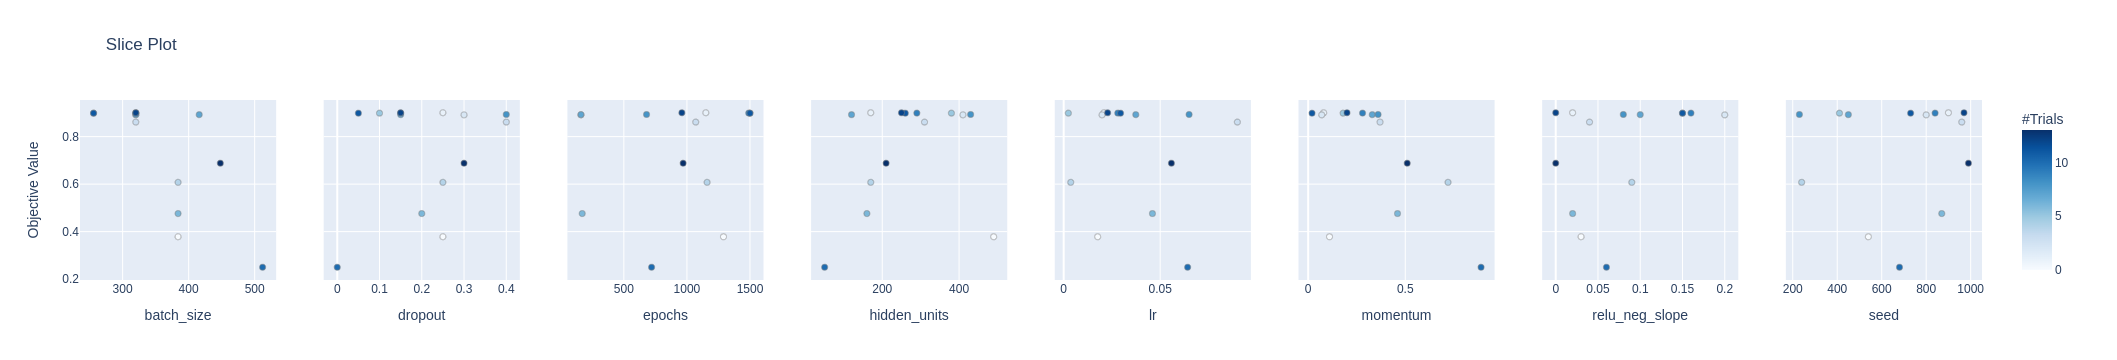

In [22]:
plot_slice(study)

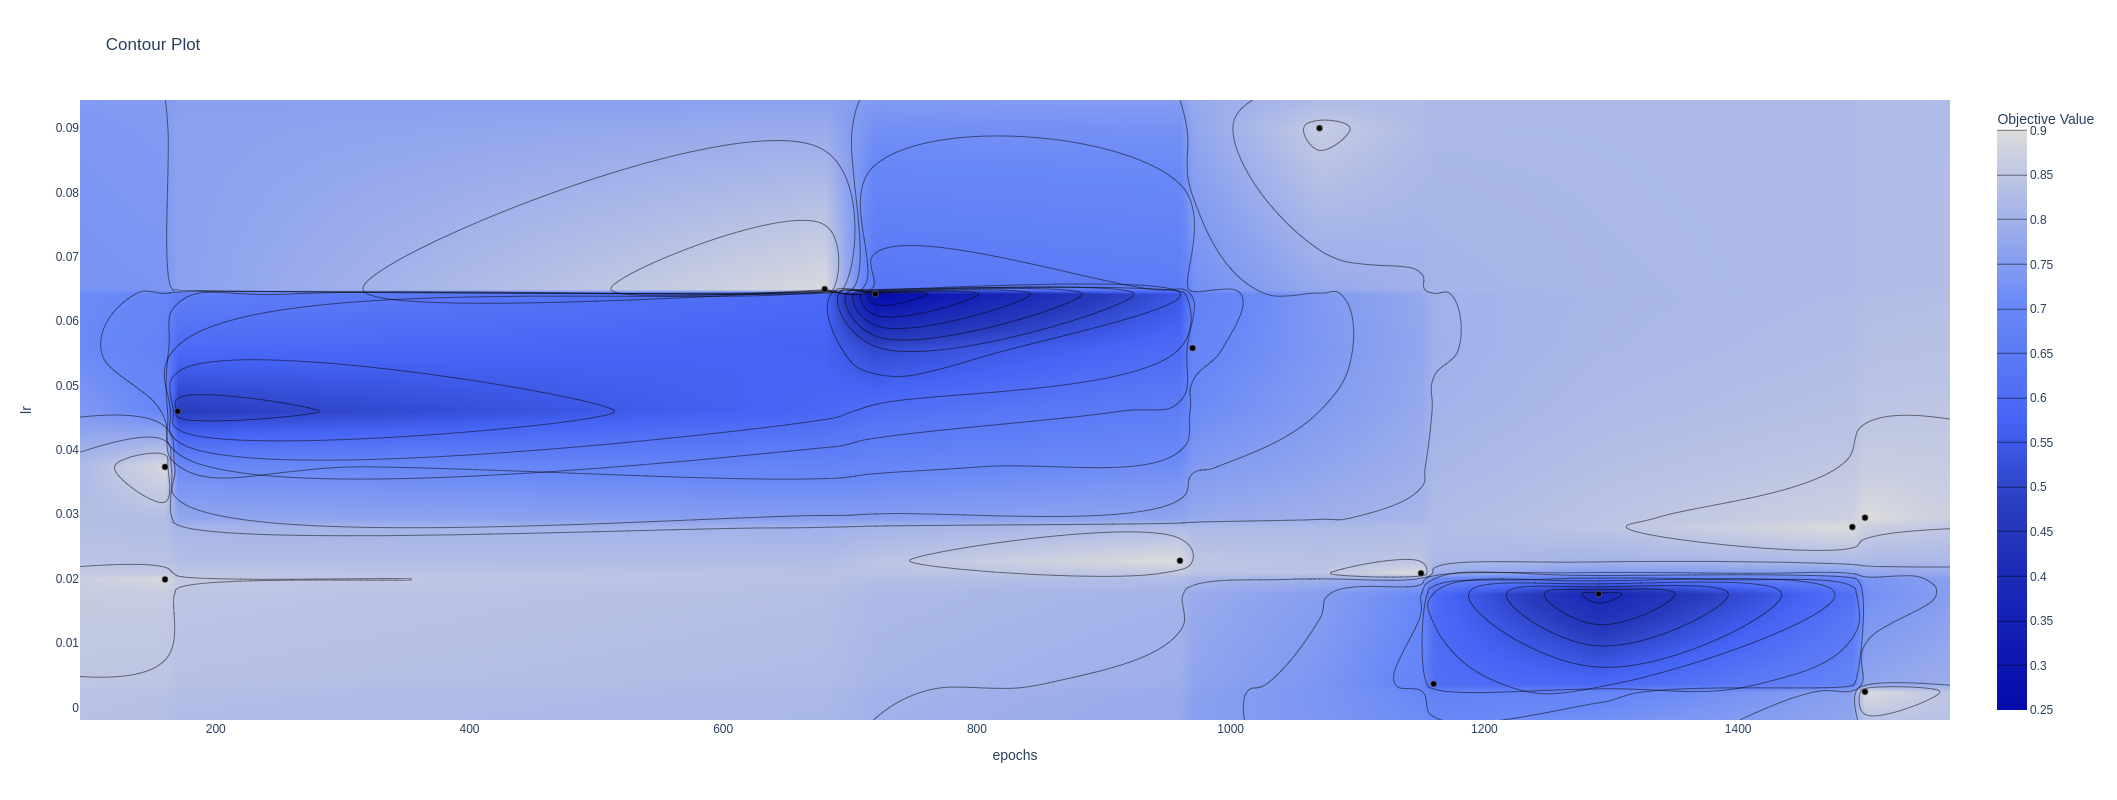

In [23]:
fig = plot_contour(study, params=["epochs", "lr"])
fig.update_layout(width=1000, height=800)

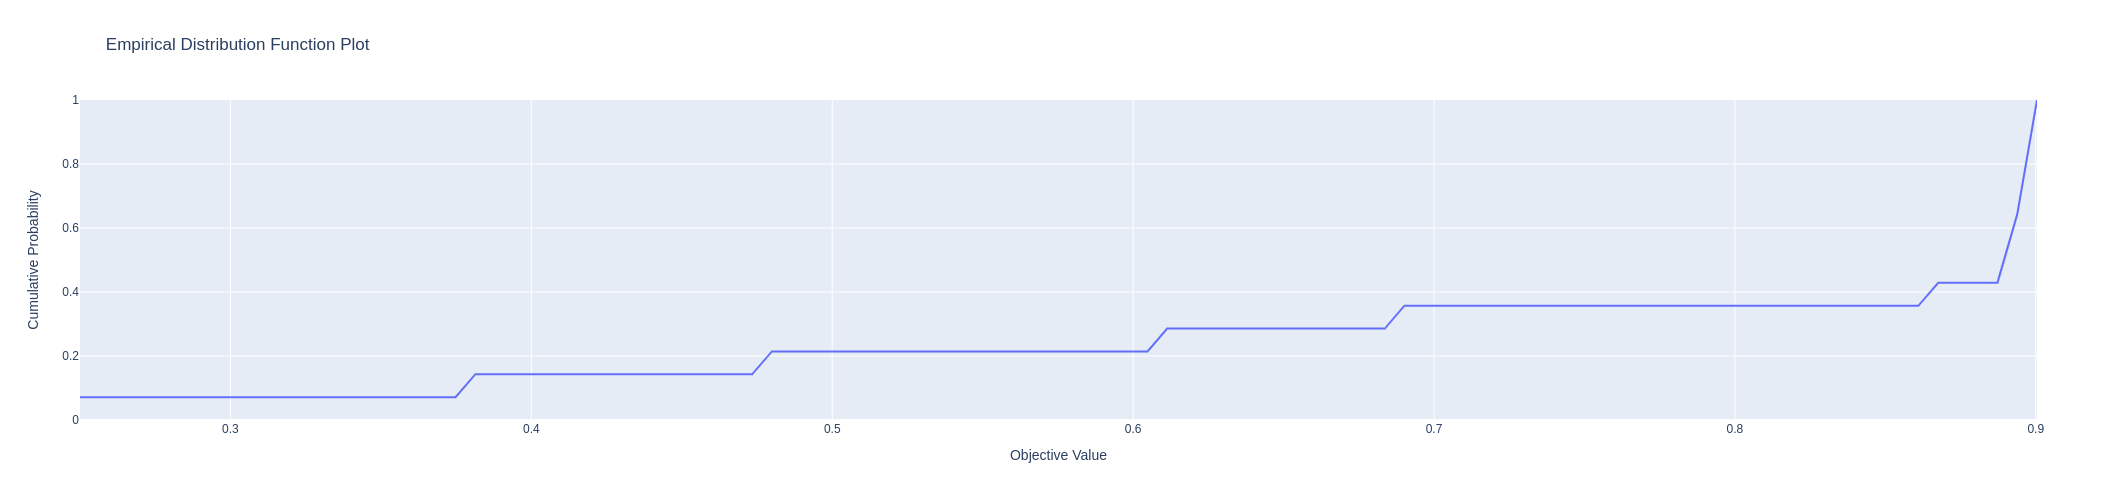

In [24]:
fig = plot_edf(study)
fig.update_layout(width=500, height=500)

ModeResult(mode=array([0.25]), count=array([1]))


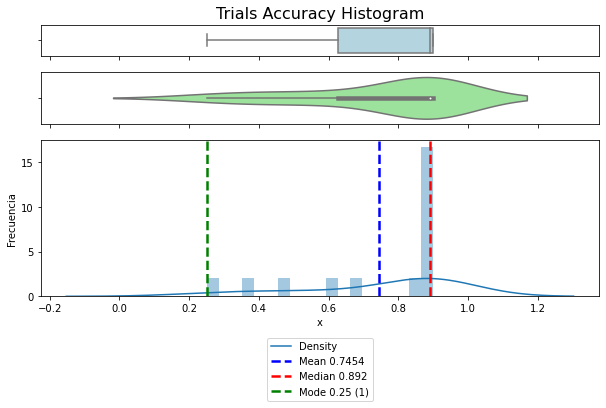

In [25]:
plot_trials_metric_dist(study)

In [26]:
import random

seeds             = random.sample(range(1,1000), 5)
best_hyper_params = study.best_trial.params.copy()
accs              = []

for seed in seeds:
    print('Seed:', seed)
    acc = train(
        X,
        y, 
        params = dict_join({ 'seed': seed }, best_hyper_params),
        callbacks = [Logger(metrics=['epoch', 'val_acc'])]
    )
    accs.append(acc)

Seed: 573


2021-12-21 23:50:29,357 ForkPoolWorker-338 root INFO Fold 2
2021-12-21 23:50:29,362 ForkPoolWorker-339 root INFO Fold 3
2021-12-21 23:50:29,368 ForkPoolWorker-340 root INFO Fold 4
2021-12-21 23:50:29,374 ForkPoolWorker-341 root INFO Fold 5
2021-12-21 23:50:29,350 ForkPoolWorker-337 root INFO Fold 1
2021-12-21 23:50:33,991 ForkPoolWorker-339 root INFO {'epoch': 50, 'train_acc': 0.8629036481862613, 'val_acc': 0.8582615751553895}
2021-12-21 23:50:33,991 ForkPoolWorker-341 root INFO {'epoch': 50, 'train_acc': 0.8952411130994342, 'val_acc': 0.8952145234376299}
2021-12-21 23:50:33,991 ForkPoolWorker-341 root INFO {'epoch': 50, 'val_acc': 0.8952145234376299}
2021-12-21 23:50:33,991 ForkPoolWorker-339 root INFO {'epoch': 50, 'val_acc': 0.8582615751553895}
2021-12-21 23:50:34,000 ForkPoolWorker-340 root INFO {'epoch': 50, 'train_acc': 0.8487391070428877, 'val_acc': 0.8454408944805321}
2021-12-21 23:50:34,001 ForkPoolWorker-340 root INFO {'epoch': 50, 'val_acc': 0.8454408944805321}
2021-12-21 23

Seed: 753


2021-12-21 23:52:14,842 ForkPoolWorker-362 root INFO Fold 2
2021-12-21 23:52:14,848 ForkPoolWorker-363 root INFO Fold 3
2021-12-21 23:52:14,853 ForkPoolWorker-364 root INFO Fold 4
2021-12-21 23:52:14,838 ForkPoolWorker-361 root INFO Fold 1
2021-12-21 23:52:14,859 ForkPoolWorker-365 root INFO Fold 5
2021-12-21 23:52:19,294 ForkPoolWorker-362 root INFO {'epoch': 50, 'train_acc': 0.8909276050342658, 'val_acc': 0.8843424564219522}
2021-12-21 23:52:19,295 ForkPoolWorker-362 root INFO {'epoch': 50, 'val_acc': 0.8843424564219522}
2021-12-21 23:52:19,311 ForkPoolWorker-363 root INFO {'epoch': 50, 'train_acc': 0.8629036481862613, 'val_acc': 0.8582615751553895}
2021-12-21 23:52:19,311 ForkPoolWorker-363 root INFO {'epoch': 50, 'val_acc': 0.8582615751553895}
2021-12-21 23:52:19,438 ForkPoolWorker-365 root INFO {'epoch': 50, 'train_acc': 0.8952411130994342, 'val_acc': 0.8952145234376299}
2021-12-21 23:52:19,438 ForkPoolWorker-365 root INFO {'epoch': 50, 'val_acc': 0.8952145234376299}
2021-12-21 23

Seed: 766


2021-12-21 23:54:00,264 ForkPoolWorker-386 root INFO Fold 2
2021-12-21 23:54:00,270 ForkPoolWorker-387 root INFO Fold 3
2021-12-21 23:54:00,276 ForkPoolWorker-388 root INFO Fold 4
2021-12-21 23:54:00,280 ForkPoolWorker-389 root INFO Fold 5
2021-12-21 23:54:00,260 ForkPoolWorker-385 root INFO Fold 1
2021-12-21 23:54:04,701 ForkPoolWorker-386 root INFO {'epoch': 50, 'train_acc': 0.8909276050342658, 'val_acc': 0.8843424564219522}
2021-12-21 23:54:04,702 ForkPoolWorker-386 root INFO {'epoch': 50, 'val_acc': 0.8843424564219522}
2021-12-21 23:54:04,737 ForkPoolWorker-389 root INFO {'epoch': 50, 'train_acc': 0.8952411130994342, 'val_acc': 0.8952145234376299}
2021-12-21 23:54:04,737 ForkPoolWorker-389 root INFO {'epoch': 50, 'val_acc': 0.8952145234376299}
2021-12-21 23:54:04,767 ForkPoolWorker-387 root INFO {'epoch': 50, 'train_acc': 0.8629036481862613, 'val_acc': 0.8582615751553895}
2021-12-21 23:54:04,768 ForkPoolWorker-387 root INFO {'epoch': 50, 'val_acc': 0.8582615751553895}
2021-12-21 23

Seed: 993


2021-12-21 23:55:45,228 ForkPoolWorker-410 root INFO Fold 2
2021-12-21 23:55:45,234 ForkPoolWorker-411 root INFO Fold 3
2021-12-21 23:55:45,241 ForkPoolWorker-412 root INFO Fold 4
2021-12-21 23:55:45,246 ForkPoolWorker-413 root INFO Fold 5
2021-12-21 23:55:45,223 ForkPoolWorker-409 root INFO Fold 1
2021-12-21 23:55:49,702 ForkPoolWorker-411 root INFO {'epoch': 50, 'train_acc': 0.8629036481862613, 'val_acc': 0.8582615751553895}
2021-12-21 23:55:49,703 ForkPoolWorker-411 root INFO {'epoch': 50, 'val_acc': 0.8582615751553895}
2021-12-21 23:55:49,705 ForkPoolWorker-409 root INFO {'epoch': 50, 'train_acc': 0.8857131015241662, 'val_acc': 0.8847573569776563}
2021-12-21 23:55:49,705 ForkPoolWorker-409 root INFO {'epoch': 50, 'val_acc': 0.8847573569776563}
2021-12-21 23:55:49,757 ForkPoolWorker-412 root INFO {'epoch': 50, 'train_acc': 0.8487391070428877, 'val_acc': 0.8454408944805321}
2021-12-21 23:55:49,758 ForkPoolWorker-412 root INFO {'epoch': 50, 'val_acc': 0.8454408944805321}
2021-12-21 23

Seed: 217


2021-12-21 23:57:31,423 ForkPoolWorker-434 root INFO Fold 2
2021-12-21 23:57:31,428 ForkPoolWorker-435 root INFO Fold 3
2021-12-21 23:57:31,434 ForkPoolWorker-436 root INFO Fold 4
2021-12-21 23:57:31,441 ForkPoolWorker-437 root INFO Fold 5
2021-12-21 23:57:31,418 ForkPoolWorker-433 root INFO Fold 1
2021-12-21 23:57:35,841 ForkPoolWorker-436 root INFO {'epoch': 50, 'train_acc': 0.8487391070428877, 'val_acc': 0.8454408944805321}
2021-12-21 23:57:35,841 ForkPoolWorker-436 root INFO {'epoch': 50, 'val_acc': 0.8454408944805321}
2021-12-21 23:57:35,947 ForkPoolWorker-435 root INFO {'epoch': 50, 'train_acc': 0.8629036481862613, 'val_acc': 0.8582615751553895}
2021-12-21 23:57:35,948 ForkPoolWorker-435 root INFO {'epoch': 50, 'val_acc': 0.8582615751553895}
2021-12-21 23:57:36,002 ForkPoolWorker-433 root INFO {'epoch': 50, 'train_acc': 0.8857131015241662, 'val_acc': 0.8847573569776563}
2021-12-21 23:57:36,003 ForkPoolWorker-433 root INFO {'epoch': 50, 'val_acc': 0.8847573569776563}
2021-12-21 23

ModeResult(mode=array([0.90040193]), count=array([5]))


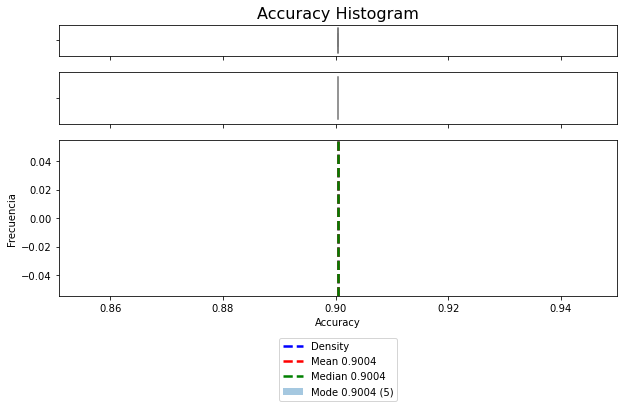

In [27]:
plot_hist(
    lambda: accs,
    bins_fn = local_bin(10),
    xlabel  = 'Accuracy'
)

### Predict on test

In [28]:
def train_model(X, y, params):
    np.random.seed(params['seed'])
        
    model = MyModel(
        n_units        = [X.shape[1], params['hidden_units'], y.shape[1]],
        lr             = params['lr'],
        momentum       = params['momentum'],
        dropout        = params['dropout'],
        negative_slope = params['relu_neg_slope']
    )

    model.fit(
        train_set    = (X, y), 
        val_set      = None, 
        batch_size   = params['batch_size'],
        epochs       = params['epochs']
    )

    return model

In [29]:
def preprocess2(df):
    features = df[feature_columns]

    for col in CAL_COLS:
        features = pd.concat([features, pd.get_dummies(features[col], dummy_na=False)], axis=1)
    features = features.drop(CAL_COLS, axis=1)
    
    target = pd.get_dummies(df[[TARGET]], dummy_na=False) if TARGET in df.columns else None

    return features, target

In [30]:
test_set = pd.read_csv('./dataset/fifa2021_test.csv')
test_features, _ = preprocess2(test_set)

In [31]:
test_model = train_model(X, y, params = dict_join({ 'seed': seed }, best_hyper_params))

In [32]:
y_pred = to_single_col_df(test_model.predict(test_features))
y_pred

any
0       1
1       1
2       3
3       3
4       3
...   ...
5904    0
5905    0
5906    2
5907    3
5908    3

[5909 rows x 1 columns]

In [33]:
mapping = ['DEF', 'FWD', 'GK', 'MID']

test_data = pd.DataFrame(data={
    'ID': test_set.ID.values,
    'Category': [mapping[x] for x in y_pred.values.reshape((-1, ))]
})
test_data

ID Category
0     153079      FWD
1     239085      FWD
2     158023      MID
3     215914      MID
4     200145      MID
...      ...      ...
5904  247811      DEF
5905  256251      DEF
5906  254564       GK
5907  231637      MID
5908  244303      MID

[5909 rows x 2 columns]

In [34]:
test_data.to_csv('result.csv', index=False)